### Image Size Changes:

1. Update args dictionary in notebook
2. Update GlaucomaDataset to resize to appropriate size
3. Update feat_sizes
4. Update the sam_prompt_encoder (via notebook cell 3)
5. Update _bb_feat_sizes in sam2_image_predictor.py

In [41]:
# General packages
import torch
import numpy as np
import pandas as pd
import sys
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Medical-SAM2 imports
from sam2_train.sam2_image_predictor import SAM2ImagePredictor
from sam2_train.build_sam import build_sam2
from sam2_train.modeling.sam2_utils import MLP

# Data processing
sys.path.append("../unet")
from GlaucomaDataset import GlaucomaDatasetBoundingBoxes
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Training imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [2]:
# Load in the base SAM2 small model
med_sam_2 = build_sam2("sam2_hiera_s", "./checkpoints/sam2_hiera_small.pt", device="cuda")

In [ ]:
# Update the number of mask outputs to be 2

med_sam_2.sam_mask_decoder.num_multimask_outputs = 2
med_sam_2.sam_mask_decoder.num_mask_tokens = 1 + med_sam_2.sam_mask_decoder.num_multimask_outputs

In [ ]:
# Model architecture updates for working with different image sizes

# 256x256 input images 
# med_sam_2.sam_prompt_encoder.image_embedding_size = (16, 16)
# med_sam_2.sam_prompt_encoder.input_image_size = (256, 256)
# med_sam_2.sam_prompt_encoder.mask_input_size = (64, 64)
# med_sam_2.image_size = 256


# 512x512 input images
# med_sam_2.sam_prompt_encoder.image_embedding_size = (32, 32)
# med_sam_2.sam_prompt_encoder.input_image_size = (512, 512)
# med_sam_2.sam_prompt_encoder.mask_input_size = (128, 128)
# med_sam_2.image_size = 512

In [5]:
def dice_score(pred_mask: torch.Tensor, gt_mask: torch.Tensor, smooth: float = 1e-6) -> torch.Tensor:
    """
    Calculate the Dice score for a single pair of predicted and ground truth masks.

    Args:
        pred_mask (torch.Tensor): Predicted mask of shape [H, W] with values between 0 and 1.
        gt_mask (torch.Tensor): Ground truth mask of shape [H, W] with binary values {0, 1}.
        smooth (float): A small constant added to avoid division by zero.

    Returns:
        torch.Tensor: The Dice score (scalar tensor).
    """
    # Flatten the masks to 1D vectors
    pred_flat = pred_mask.contiguous().view(-1)
    gt_flat   = gt_mask.contiguous().view(-1)
    
    # Compute the intersection and the sums of masks
    intersection = (pred_flat * gt_flat).sum()
    sum_masks = pred_flat.sum() + gt_flat.sum()
    
    # Compute Dice score
    dice = (2.0 * intersection + smooth) / (sum_masks + smooth)
    return dice

In [6]:
# Functions for displaying masks and prompts on final predicted masks

np.random.seed(42)

def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    num_masks = len(masks)
    fig, axs = plt.subplots(1, num_masks, figsize=(10 * num_masks, 10))  # Horizontal layout
    if num_masks == 1:
        axs = [axs]  # Ensure it's iterable
    for i, (mask, score) in enumerate(zip(masks, scores)):
        ax = axs[i]
        ax.imshow(image)
        show_mask(mask, ax, borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, ax)
        if box_coords is not None:
            show_box(box_coords, ax)
        if num_masks > 1:
            ax.set_title("Optic Disc Mask" if i == 0 else "Optic Cup Mask", fontsize=18)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
# Training function for Medical-SAM2

GPUdevice = torch.device('cuda')
pos_weight = torch.ones([1]).cuda(device=GPUdevice)*2
criterion_G = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
mask_type = torch.float32

torch.backends.cudnn.benchmark = True

def train_sam(args, net: nn.Module, optimizer, train_loader, epoch):
    # use bfloat16 for the entire notebook
    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    if torch.cuda.get_device_properties(0).major >= 8:
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    
    # train mode
    net.train()
    optimizer.zero_grad()

    # init
    epoch_loss = 0
    epoch_dice = 0
    memory_bank_list = []
    lossfunc = criterion_G

    # Update to match the input image sizes
    feat_sizes = [(256, 256), (128, 128), (64, 64)] # 1024x1024 images
    # feat_sizes = [(128,128), (64,64), (32,32)] # 512x512 images
    # feat_sizes = [(64, 64), (32, 32), (16, 16)] # 256x256 images


    with tqdm(total=len(train_loader), desc=f'Epoch {epoch}', unit='img') as pbar:
        for ind, pack in enumerate(train_loader):
            
            to_cat_memory = []
            to_cat_memory_pos = []
            to_cat_image_embed = []

            # input image and gt masks
            imgs = pack['image'].to(dtype = mask_type, device = GPUdevice)
            masks = pack['mask'].to(dtype = mask_type, device = GPUdevice)
            name = pack['image_filename']

            # click prompt: unsqueeze to indicate only one click, add more click across this dimension
            if 'bbox' in pack:
                # Assuming bbox shape is [batch, 4]; adjust unsqueeze if more than one box is expected.
                boxes = pack['bbox'].unsqueeze(1).to(device=GPUdevice, dtype=torch.float)
            else:
                boxes = None

            '''Train image encoder'''                    
            backbone_out = net.forward_image(imgs)
            _, vision_feats, vision_pos_embeds, _ = net._prepare_backbone_features(backbone_out)
            
            # dimension hint for your future use (in reference to 1024x1024 images)
            # vision_feats: list: length = 3
            # vision_feats[0]: torch.Size([65536, batch, 32])
            # vision_feats[1]: torch.Size([16384, batch, 64])
            # vision_feats[2]: torch.Size([4096, batch, 256])
            # vision_pos_embeds[0]: torch.Size([65536, batch, 256])
            # vision_pos_embeds[1]: torch.Size([16384, batch, 256])
            # vision_pos_embeds[2]: torch.Size([4096, batch, 256])
            
            

            '''Train memory attention to condition on meomory bank'''         
            B = vision_feats[-1].size(1)  # batch size 
            
            if len(memory_bank_list) == 0:
                vision_feats[-1] = vision_feats[-1] + torch.nn.Parameter(torch.zeros(1, B, net.hidden_dim)).to(device="cuda")
                vision_pos_embeds[-1] = vision_pos_embeds[-1] + torch.nn.Parameter(torch.zeros(1, B, net.hidden_dim)).to(device="cuda")
                
            else:
                for element in memory_bank_list:
                    to_cat_memory.append((element[0]).cuda(non_blocking=True).flatten(2).permute(2, 0, 1)) # maskmem_features
                    to_cat_memory_pos.append((element[1]).cuda(non_blocking=True).flatten(2).permute(2, 0, 1)) # maskmem_pos_enc
                    to_cat_image_embed.append((element[3]).cuda(non_blocking=True)) # image_embed

                memory_stack_ori = torch.stack(to_cat_memory, dim=0)
                memory_pos_stack_ori = torch.stack(to_cat_memory_pos, dim=0)
                image_embed_stack_ori = torch.stack(to_cat_image_embed, dim=0)
 
                vision_feats_temp = vision_feats[-1].permute(1, 0, 2).reshape(B, -1, 64, 64) 
                vision_feats_temp = vision_feats_temp.reshape(B, -1)

                image_embed_stack_ori = F.normalize(image_embed_stack_ori, p=2, dim=1)
                vision_feats_temp = F.normalize(vision_feats_temp, p=2, dim=1)
                similarity_scores = torch.mm(image_embed_stack_ori, vision_feats_temp.t()).t()
                
                similarity_scores = F.softmax(similarity_scores, dim=1) 
                sampled_indices = torch.multinomial(similarity_scores, num_samples=B, replacement=True).squeeze(1)  # Shape [batch_size, 16]

                memory_stack_ori_new = (memory_stack_ori[sampled_indices].squeeze(3).permute(1, 2, 0, 3))
                memory = memory_stack_ori_new.reshape(-1, memory_stack_ori_new.size(2), memory_stack_ori_new.size(3))

                memory_pos_stack_new = (memory_pos_stack_ori[sampled_indices].squeeze(3).permute(1, 2, 0, 3))
                memory_pos = memory_pos_stack_new.reshape(-1, memory_stack_ori_new.size(2), memory_stack_ori_new.size(3))


                vision_feats[-1] = net.memory_attention(
                    curr=[vision_feats[-1]],
                    curr_pos=[vision_pos_embeds[-1]],
                    memory=memory,
                    memory_pos=memory_pos,
                    num_obj_ptr_tokens=0
                    )


            feats = [feat.permute(1, 2, 0).reshape(B, -1, *feat_size) 
                     for feat, feat_size in zip(vision_feats[::-1], feat_sizes[::-1])][::-1]
            
            image_embed = feats[-1]
            high_res_feats = feats[:-1]
            
            # feats[0]: torch.Size([batch, 32, 256, 256]) #high_res_feats part1
            # feats[1]: torch.Size([batch, 64, 128, 128]) #high_res_feats part2
            # feats[2]: torch.Size([batch, 256, 64, 64]) #image_embed

            '''prompt encoder'''         
            with torch.no_grad():
                if (ind%5) == 0:
                    #points=(coords_torch, labels_torch) # input shape: ((batch, n, 2), (batch, n))
                    flag = True
                else:
                    points=None
                    flag = False

                se, de = net.sam_prompt_encoder(
                    points=None,   # No point prompts used
                    boxes=boxes,   # Use the bounding boxes from the data
                    masks=None,
                    batch_size=B,
                )
            # dimension hint for your future use
            # se: torch.Size([batch, n+1, 256])
            # de: torch.Size([batch, 256, 64, 64])

            '''train mask decoder'''       
            low_res_multimasks, iou_predictions, sam_output_tokens, object_score_logits = net.sam_mask_decoder(
                    image_embeddings=image_embed,
                    image_pe=net.sam_prompt_encoder.get_dense_pe(), 
                    sparse_prompt_embeddings=se,
                    dense_prompt_embeddings=de, 
                    multimask_output=True, # args.multimask_output if you want multiple masks
                    repeat_image=False,  # the image is already batched
                    high_res_features = high_res_feats
                )
            # dimension hint for your future use
            # low_res_multimasks: torch.Size([batch, multimask_output, 256, 256])
            # iou_predictions.shape:torch.Size([batch, multimask_output])
            # sam_output_tokens.shape:torch.Size([batch, multimask_output, 256])
            # object_score_logits.shape:torch.Size([batch, 1])
            
            
            # resize prediction
            pred = F.interpolate(low_res_multimasks,size=(args['out_size'],args['out_size']))
            high_res_multimasks = F.interpolate(low_res_multimasks, size=(args['image_size'], args['image_size']),
                                                mode="bilinear", align_corners=False)

            '''memory encoder'''       
            # new caluculated memory features
            maskmem_features, maskmem_pos_enc = net._encode_new_memory(
                current_vision_feats=vision_feats,
                feat_sizes=feat_sizes,
                pred_masks_high_res=high_res_multimasks[:, :1, :, :],
                is_mask_from_pts=flag)  
            # dimension hint for your future use
            # maskmem_features: torch.Size([batch, 64, 64, 64])
            # maskmem_pos_enc: [torch.Size([batch, 64, 64, 64])]
                
            maskmem_features = maskmem_features.to(torch.bfloat16)
            maskmem_features = maskmem_features.to(device=GPUdevice, non_blocking=True)
            maskmem_pos_enc = maskmem_pos_enc[0].to(torch.bfloat16)
            maskmem_pos_enc = maskmem_pos_enc.to(device=GPUdevice, non_blocking=True)


            # add single maskmem_features, maskmem_pos_enc, iou
            if len(memory_bank_list) < args['memory_bank_size']:
                for batch in range(maskmem_features.size(0)):
                    memory_bank_list.append([(maskmem_features[batch].unsqueeze(0)).detach(),
                                             (maskmem_pos_enc[batch].unsqueeze(0)).detach(),
                                             iou_predictions[batch, 0],
                                             image_embed[batch].reshape(-1).detach()])
            
            else:
                for batch in range(maskmem_features.size(0)):
                    
                    # current simlarity matrix in existing memory bank
                    memory_bank_maskmem_features_flatten = [element[0].reshape(-1) for element in memory_bank_list]
                    memory_bank_maskmem_features_flatten = torch.stack(memory_bank_maskmem_features_flatten)

                    # normalise
                    memory_bank_maskmem_features_norm = F.normalize(memory_bank_maskmem_features_flatten, p=2, dim=1)
                    current_similarity_matrix = torch.mm(memory_bank_maskmem_features_norm,
                                                         memory_bank_maskmem_features_norm.t())

                    # replace diagonal (diagnoal always simiarity = 1)
                    current_similarity_matrix_no_diag = current_similarity_matrix.clone()
                    diag_indices = torch.arange(current_similarity_matrix_no_diag.size(0))
                    current_similarity_matrix_no_diag[diag_indices, diag_indices] = float('-inf')

                    # first find the minimum similarity from memory feature and the maximum similarity from memory bank
                    single_key_norm = F.normalize(maskmem_features[batch].reshape(-1), p=2, dim=0).unsqueeze(1)
                    similarity_scores = torch.mm(memory_bank_maskmem_features_norm, single_key_norm).squeeze()
                    min_similarity_index = torch.argmin(similarity_scores) 
                    max_similarity_index = torch.argmax(current_similarity_matrix_no_diag[min_similarity_index])

                    # replace with less similar object
                    if similarity_scores[min_similarity_index] < current_similarity_matrix_no_diag[min_similarity_index][max_similarity_index]:
                        # soft iou, not stricly greater than current iou
                        if iou_predictions[batch, 0] > memory_bank_list[max_similarity_index][2] - 0.1:
                            memory_bank_list.pop(max_similarity_index) 
                            memory_bank_list.append([(maskmem_features[batch].unsqueeze(0)).detach(),
                                                     (maskmem_pos_enc[batch].unsqueeze(0)).detach(),
                                                     iou_predictions[batch, 0],
                                                     image_embed[batch].reshape(-1).detach()])

            # backpropagation
            loss_disc = lossfunc(pred[:, 0, :, :], masks[:, 0, :, :])
            loss_cup  = lossfunc(pred[:, 1, :, :], masks[:, 1, :, :])
            dice_disc = dice_score(torch.sigmoid(pred[:, 0, :, :]), masks[:, 0, :, :])
            dice_cup  = dice_score(torch.sigmoid(pred[:, 1, :, :]), masks[:, 1, :, :])

            loss = .3 * loss_disc + .7 * loss_cup
            dice = (dice_disc + dice_cup) / 2

            pbar.set_postfix(**{'loss (batch)': loss.item()})
            epoch_loss += loss.item()
            epoch_dice += dice.item()

            loss.backward()
            optimizer.step()
            
            optimizer.zero_grad()

            # Cleanup large intermediate tensors that are no longer needed.
            del backbone_out, vision_feats, vision_pos_embeds, feats, image_embed, high_res_feats, se, de, low_res_multimasks, iou_predictions, sam_output_tokens, object_score_logits, pred

            # Optionally free cached memory.
            if ind % 10 == 0:  # For instance, every 10 iterations
                torch.cuda.empty_cache()

            pbar.update()

    return epoch_loss/len(train_loader), epoch_dice/len(train_loader)


In [16]:
# Validation function for Medical-SAM2
def validation_sam(args, val_loader, epoch, net: nn.Module, clean_dir=True):

    # use bfloat16 for the entire notebook
    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    if torch.cuda.get_device_properties(0).major >= 8:
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True


    # eval mode
    net.eval()

    n_val = len(val_loader) 
    threshold = (0.1, 0.3, 0.5, 0.7, 0.9)
    GPUdevice = torch.device('cuda:' + str(0))

    # init
    lossfunc = criterion_G
    memory_bank_list = []
    feat_sizes = [(256, 256), (128, 128), (64, 64)] # 1024x1024
    # feat_sizes = [(64, 64), (32, 32), (16, 16)] # 256x256
    # feat_sizes = [(128,128), (64,64), (32,32)] # 512x512
    total_loss = 0
    total_eiou = 0
    total_dice = 0


    with tqdm(total=n_val, desc='Validation round', unit='batch', leave=False) as pbar:
        for ind, pack in enumerate(val_loader):
            to_cat_memory = []
            to_cat_memory_pos = []
            to_cat_image_embed = []

            # input image and gt masks
            imgs = pack['image'].to(dtype = mask_type, device = GPUdevice)
            masks = pack['mask'].to(dtype = mask_type, device = GPUdevice)
            name = pack['image_filename']

            # click prompt: unsqueeze to indicate only one click, add more click across this dimension
            if 'bbox' in pack:
                # Assuming bbox shape is [batch, 4]; adjust unsqueeze if more than one box is expected.
                boxes = pack['bbox'].unsqueeze(1).to(device=GPUdevice, dtype=torch.float)
            else:
                boxes = None



            '''test'''
            with torch.no_grad():

                """ image encoder """
                backbone_out = net.forward_image(imgs)
                _, vision_feats, vision_pos_embeds, _ = net._prepare_backbone_features(backbone_out)
                B = vision_feats[-1].size(1) 

                """ memory condition """
                if len(memory_bank_list) == 0:
                    vision_feats[-1] = vision_feats[-1] + torch.nn.Parameter(torch.zeros(1, B, net.hidden_dim)).to(device="cuda")
                    vision_pos_embeds[-1] = vision_pos_embeds[-1] + torch.nn.Parameter(torch.zeros(1, B, net.hidden_dim)).to(device="cuda")

                else:
                    for element in memory_bank_list:
                        to_cat_memory.append(element[0].cuda(non_blocking=True).flatten(2).permute(2, 0, 1))
                        to_cat_memory_pos.append(element[1].cuda(non_blocking=True).flatten(2).permute(2, 0, 1))
                        to_cat_image_embed.append((element[3]).cuda(non_blocking=True)) # image_embed
                        
                    memory_stack_ori = torch.stack(to_cat_memory, dim=0)
                    memory_pos_stack_ori = torch.stack(to_cat_memory_pos, dim=0)
                    image_embed_stack_ori = torch.stack(to_cat_image_embed, dim=0)

                    vision_feats_temp = vision_feats[-1].permute(1, 0, 2).reshape(B, -1, 64, 64) 
                    vision_feats_temp = vision_feats_temp.reshape(B, -1)

                    image_embed_stack_ori = F.normalize(image_embed_stack_ori, p=2, dim=1)
                    vision_feats_temp = F.normalize(vision_feats_temp, p=2, dim=1)
                    similarity_scores = torch.mm(image_embed_stack_ori, vision_feats_temp.t()).t()

                    similarity_scores = F.softmax(similarity_scores, dim=1) 
                    sampled_indices = torch.multinomial(similarity_scores, num_samples=B, replacement=True).squeeze(1)  # Shape [batch_size, 16]

                    memory_stack_ori_new = (memory_stack_ori[sampled_indices].squeeze(3).permute(1, 2, 0, 3))
                    memory = memory_stack_ori_new.reshape(-1, memory_stack_ori_new.size(2), memory_stack_ori_new.size(3))

                    memory_pos_stack_new = (memory_pos_stack_ori[sampled_indices].squeeze(3).permute(1, 2, 0, 3))
                    memory_pos = memory_pos_stack_new.reshape(-1, memory_stack_ori_new.size(2), memory_stack_ori_new.size(3))



                    vision_feats[-1] = net.memory_attention(
                        curr=[vision_feats[-1]],
                        curr_pos=[vision_pos_embeds[-1]],
                        memory=memory,
                        memory_pos=memory_pos,
                        num_obj_ptr_tokens=0
                        )

                feats = [feat.permute(1, 2, 0).reshape(B, -1, *feat_size) 
                        for feat, feat_size in zip(vision_feats[::-1], feat_sizes[::-1])][::-1]
                
                image_embed = feats[-1]
                high_res_feats = feats[:-1]

                """ prompt encoder """
                if (ind%5) == 0:
                    flag = True
                    # points = (coords_torch, labels_torch)

                else:
                    flag = False
                    points = None

                se, de = net.sam_prompt_encoder(
                    points=None, 
                    boxes=boxes,
                    masks=None,
                    batch_size=B,
                )

                low_res_multimasks, iou_predictions, sam_output_tokens, object_score_logits = net.sam_mask_decoder(
                    image_embeddings=image_embed,
                    image_pe=net.sam_prompt_encoder.get_dense_pe(), 
                    sparse_prompt_embeddings=se,
                    dense_prompt_embeddings=de, 
                    multimask_output=True, 
                    repeat_image=False,  
                    high_res_features = high_res_feats
                )

                # prediction
                pred = F.interpolate(low_res_multimasks,size=(args['out_size'],args['out_size']))
                high_res_multimasks = F.interpolate(low_res_multimasks, size=(args['image_size'], args['image_size']),
                                                mode="bilinear", align_corners=False)

                """ memory encoder """
                maskmem_features, maskmem_pos_enc = net._encode_new_memory( 
                    current_vision_feats=vision_feats,
                    feat_sizes=feat_sizes,
                    pred_masks_high_res=high_res_multimasks[:, :1, :, :],
                    is_mask_from_pts=flag)  
                    
                maskmem_features = maskmem_features.to(torch.bfloat16)
                maskmem_features = maskmem_features.to(device=GPUdevice, non_blocking=True)
                maskmem_pos_enc = maskmem_pos_enc[0].to(torch.bfloat16)
                maskmem_pos_enc = maskmem_pos_enc.to(device=GPUdevice, non_blocking=True)


                """ memory bank """
                if len(memory_bank_list) < args['memory_bank_size']:
                    for batch in range(maskmem_features.size(0)):
                        memory_bank_list.append([(maskmem_features[batch].unsqueeze(0)),
                                                 (maskmem_pos_enc[batch].unsqueeze(0)),
                                                 iou_predictions[batch, 0],
                                                 image_embed[batch].reshape(-1).detach()])
                
                else:
                    for batch in range(maskmem_features.size(0)):
                        
                        memory_bank_maskmem_features_flatten = [element[0].reshape(-1) for element in memory_bank_list]
                        memory_bank_maskmem_features_flatten = torch.stack(memory_bank_maskmem_features_flatten)

                        memory_bank_maskmem_features_norm = F.normalize(memory_bank_maskmem_features_flatten, p=2, dim=1)
                        current_similarity_matrix = torch.mm(memory_bank_maskmem_features_norm,
                                                             memory_bank_maskmem_features_norm.t())

                        current_similarity_matrix_no_diag = current_similarity_matrix.clone()
                        diag_indices = torch.arange(current_similarity_matrix_no_diag.size(0))
                        current_similarity_matrix_no_diag[diag_indices, diag_indices] = float('-inf')

                        single_key_norm = F.normalize(maskmem_features[batch].reshape(-1), p=2, dim=0).unsqueeze(1)
                        similarity_scores = torch.mm(memory_bank_maskmem_features_norm, single_key_norm).squeeze()
                        min_similarity_index = torch.argmin(similarity_scores) 
                        max_similarity_index = torch.argmax(current_similarity_matrix_no_diag[min_similarity_index])

                        if similarity_scores[min_similarity_index] < current_similarity_matrix_no_diag[min_similarity_index][max_similarity_index]:
                            if iou_predictions[batch, 0] > memory_bank_list[max_similarity_index][2] - 0.1:
                                memory_bank_list.pop(max_similarity_index) 
                                memory_bank_list.append([(maskmem_features[batch].unsqueeze(0)),
                                                         (maskmem_pos_enc[batch].unsqueeze(0)),
                                                         iou_predictions[batch, 0],
                                                         image_embed[batch].reshape(-1).detach()])

                # binary mask and calculate loss, iou, dice
                # total_loss += lossfunc(pred, masks)
                # pred = (pred> 0.5).float()
                # # For disc (first mask)
                # dice_disc = eval_dice(pred[:, 0, :, :], masks[:, 0, :, :])
                # iou_disc = eval_iou(pred[:, 0, :, :], masks[:, 0, :, :])
                # # For cup (second mask)
                # dice_cup = eval_dice(pred[:, 1, :, :], masks[:, 1, :, :])
                # iou_cup = eval_iou(pred[:, 1, :, :], masks[:, 1, :, :])

                loss_disc = lossfunc(pred[:, 0, :, :], masks[:, 0, :, :])
                loss_cup  = lossfunc(pred[:, 1, :, :], masks[:, 1, :, :])
                dice_disc = dice_score(torch.sigmoid(pred[:, 0, :, :]), masks[:, 0, :, :])
                dice_cup  = dice_score(torch.sigmoid(pred[:, 1, :, :]), masks[:, 1, :, :])

                loss = .3 * loss_disc + .7 * loss_cup
                dice = (dice_disc + dice_cup) / 2

                # weight the loss from the cup more because it is worse in predictions
                loss = .3 * loss_disc + .7 * loss_cup
                pbar.set_postfix(**{'loss (batch)': loss.item()})
                total_loss += loss.item()
                total_dice += dice.item()


                '''vis images'''
                # if ind % args.vis == 0:
                #     namecat = 'Test'
                #     for na in name:
                #         img_name = na
                #         namecat = namecat + img_name + '+'
                #     vis_image(imgs,pred, masks, os.path.join(args.path_helper['sample_path'], namecat+'epoch+' +str(epoch) + '.jpg'), reverse=False, points=None)
            # Cleanup large intermediate tensors that are no longer needed.
            del backbone_out, vision_feats, vision_pos_embeds, feats, image_embed, high_res_feats, se, de, low_res_multimasks, iou_predictions, sam_output_tokens, object_score_logits, pred

            # Optionally free cached memory.
            if ind % 10 == 0:  # For instance, every 10 iterations
                torch.cuda.empty_cache()    
            pbar.update()

    return total_loss/ n_val, total_dice / n_val#, tuple([total_eiou/n_val, total_dice/n_val])

## Data

In [9]:
def update_image_path(path: str) -> str:
    """
    Pulls the file name from a file path.

    Args:
        path (str): file path

    Returns:
        str: the file name
    """
    split_path = path.split("/")
    return split_path[-1]

In [10]:
# Read in the fundus images and ground truth masks
origa_path = os.path.join('..', '..', "data", "ORIGA")
images_path = os.path.join(origa_path, "Images_Square")
masks_path = os.path.join(origa_path, "Masks_Square")

img_filenames = sorted(os.listdir(images_path))
mask_filenames = sorted(os.listdir(masks_path))

# Read in the bounding boxes
bb_df = pd.read_csv("../../data/ORIGA/bounding_boxes.csv")
bb_df['image_path'] = bb_df['image_path'].apply(update_image_path)

# Update the bounding box coordinates based on the image size. Boxes were created on 512x512 images
if med_sam_2.image_size == 256:
    bb_df[['x1', 'y1', 'x2', 'y2']] //= 2
elif med_sam_2.image_size == 1024:
    bb_df[['x1', 'y1', 'x2', 'y2']] *= 2

In [11]:
# Split into train, validation, and test sets (70, 15, 15)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    img_filenames, mask_filenames, test_size=0.3, random_state=42)

val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42)

In [12]:
batch_size = 4
n_workers = 4

# Load raw data into custom PyTorch datasets
train_set = GlaucomaDatasetBoundingBoxes(images_path, masks_path, train_imgs, train_masks, bb_df, 1024)
val_set = GlaucomaDatasetBoundingBoxes(images_path, masks_path, val_imgs, val_masks, bb_df, 1024)
test_set = GlaucomaDatasetBoundingBoxes(images_path, masks_path, test_imgs, test_masks, bb_df, 1024)

# Load datasets into PyTorch DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)

In [13]:
# Training arguments
args = {
    'out_size': 1024,
    'image_size': 1024,
    'memory_bank_size': 16,
    'lr': 1e-4
}

# Freeze image encoder
for param in med_sam_2.image_encoder.parameters():
    param.requires_grad = False

# initialize Adam optimizer
optimizer = optim.Adam(med_sam_2.parameters(), lr=args['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Set to max 50 epochs
epochs = 50

In [14]:
med_sam_2 = med_sam_2.to('cuda')

In [17]:
# Initialize early stopping conditions
best_val_dice = float('-inf')
patience = 5
patience_counter = 0

# Initialize loss lists to save loss at each epoch
train_loss_list = [0] * epochs
val_loss_list = [0] * epochs

for epoch in range(epochs):
    # Run one training epoch
    train_loss, train_dice = train_sam(args, med_sam_2, optimizer, train_loader, epoch)
    print(f'Train loss: {train_loss} || @ epoch {epoch}. Train Dice: {train_dice} || @ epoch {epoch}.')
    train_loss_list[epoch] = train_loss

    # Run one validation loop
    val_loss, val_dice = validation_sam(args, val_loader, epoch, med_sam_2)
    print(f'Validation loss: {val_loss} || @ epoch {epoch}. Validation dice: {val_dice} || @ epoch {epoch}.')
    val_loss_list[epoch] = val_loss

    # Check if our model is better than the best trained model
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        state_dict_to_save = med_sam_2.state_dict()
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"Early stopping triggered @ epoch {epoch}.")
            break

# Run a final test evaluation on a holdout set
med_sam_2.load_state_dict(state_dict_to_save)
test_loss, test_dice = validation_sam(args, test_loader, 0, med_sam_2)
print(f'Test loss: {test_loss}. Test Dice: {test_dice}.')

Epoch 0: 100%|██████████| 114/114 [00:59<00:00,  1.92img/s, loss (batch)=0.031] 


Train loss: 0.040704084168139254 || @ epoch 0. Train Dice: 0.47534562333634023 || @ epoch 0.


Validation loss: 0.03320769153535366 || @ epoch 0. Validation dice: 0.4949092924594879 || @ epoch 0.


Epoch 1: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0249]


Train loss: 0.02791391994412008 || @ epoch 1. Train Dice: 0.522950946369715 || @ epoch 1.


Validation loss: 0.02573498621582985 || @ epoch 1. Validation dice: 0.53428267121315 || @ epoch 1.


Epoch 2: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0189]


Train loss: 0.022005713128141667 || @ epoch 2. Train Dice: 0.560695320498525 || @ epoch 2.


Validation loss: 0.022666379660367966 || @ epoch 2. Validation dice: 0.5211197078227997 || @ epoch 2.
No improvement. Patience: 1/5


Epoch 3: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0143]


Train loss: 0.01999715297368535 || @ epoch 3. Train Dice: 0.5664327081881071 || @ epoch 3.


Validation loss: 0.021278030276298522 || @ epoch 3. Validation dice: 0.5594550347328187 || @ epoch 3.


Epoch 4: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0159]


Train loss: 0.017784278864335073 || @ epoch 4. Train Dice: 0.6007276017937744 || @ epoch 4.


Validation loss: 0.018884642235934734 || @ epoch 4. Validation dice: 0.5817989504337311 || @ epoch 4.


Epoch 5: 100%|██████████| 114/114 [00:55<00:00,  2.07img/s, loss (batch)=0.0197]


Train loss: 0.016812226040648262 || @ epoch 5. Train Dice: 0.607348912117774 || @ epoch 5.


Validation loss: 0.01839340414851904 || @ epoch 5. Validation dice: 0.595935126543045 || @ epoch 5.


Epoch 6: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0174]


Train loss: 0.01654224952258039 || @ epoch 6. Train Dice: 0.6209707335944761 || @ epoch 6.


Validation loss: 0.017841374091804026 || @ epoch 6. Validation dice: 0.604627228975296 || @ epoch 6.


Epoch 7: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0118]


Train loss: 0.015376031235383269 || @ epoch 7. Train Dice: 0.6347203108302334 || @ epoch 7.


Validation loss: 0.016629592627286912 || @ epoch 7. Validation dice: 0.611010457277298 || @ epoch 7.


Epoch 8: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0216]


Train loss: 0.015285419741351353 || @ epoch 8. Train Dice: 0.6394743867087782 || @ epoch 8.


Validation loss: 0.016617952734231948 || @ epoch 8. Validation dice: 0.6107431244850159 || @ epoch 8.
No improvement. Patience: 1/5


Epoch 9: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0119]


Train loss: 0.014816370359703637 || @ epoch 9. Train Dice: 0.6424889721368489 || @ epoch 9.


Validation loss: 0.015948877967894078 || @ epoch 9. Validation dice: 0.6522521495819091 || @ epoch 9.


Epoch 10: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0259]


Train loss: 0.014361236644745395 || @ epoch 10. Train Dice: 0.6593294261317504 || @ epoch 10.


Validation loss: 0.01535166185349226 || @ epoch 10. Validation dice: 0.6465260016918183 || @ epoch 10.
No improvement. Patience: 1/5


Epoch 11: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0121]


Train loss: 0.014104032505042198 || @ epoch 11. Train Dice: 0.6617969373861948 || @ epoch 11.


Validation loss: 0.014953936710953712 || @ epoch 11. Validation dice: 0.6523748075962067 || @ epoch 11.


Epoch 12: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.011] 


Train loss: 0.013406133499780768 || @ epoch 12. Train Dice: 0.6737759955096663 || @ epoch 12.


Validation loss: 0.01498004224151373 || @ epoch 12. Validation dice: 0.654624639749527 || @ epoch 12.


Epoch 13: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0103]


Train loss: 0.013000578983082321 || @ epoch 13. Train Dice: 0.6820728710868902 || @ epoch 13.


Validation loss: 0.01416932225227356 || @ epoch 13. Validation dice: 0.662692596912384 || @ epoch 13.


Epoch 14: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0128] 


Train loss: 0.012896668402837557 || @ epoch 14. Train Dice: 0.6865645490194622 || @ epoch 14.


Validation loss: 0.013533878959715367 || @ epoch 14. Validation dice: 0.6840151762962341 || @ epoch 14.


Epoch 15: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0185] 


Train loss: 0.013023309662872762 || @ epoch 15. Train Dice: 0.6829503832156198 || @ epoch 15.


Validation loss: 0.01325401894748211 || @ epoch 15. Validation dice: 0.6817740345001221 || @ epoch 15.
No improvement. Patience: 1/5


Epoch 16: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0109] 


Train loss: 0.012204048901861697 || @ epoch 16. Train Dice: 0.6990529398123423 || @ epoch 16.


Validation loss: 0.013642907049506903 || @ epoch 16. Validation dice: 0.6851247644424439 || @ epoch 16.


Epoch 17: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0144] 


Train loss: 0.012018551175858368 || @ epoch 17. Train Dice: 0.7051407151054918 || @ epoch 17.


Validation loss: 0.01376611702144146 || @ epoch 17. Validation dice: 0.690059278011322 || @ epoch 17.


Epoch 18: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0183] 


Train loss: 0.01199521265695231 || @ epoch 18. Train Dice: 0.7032214507722018 || @ epoch 18.


Validation loss: 0.012753052338957786 || @ epoch 18. Validation dice: 0.6915869140625 || @ epoch 18.


Epoch 19: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00797]


Train loss: 0.01148852745986037 || @ epoch 19. Train Dice: 0.7203430857574731 || @ epoch 19.


Validation loss: 0.012145822234451771 || @ epoch 19. Validation dice: 0.7099358177185059 || @ epoch 19.


Epoch 20: 100%|██████████| 114/114 [00:55<00:00,  2.05img/s, loss (batch)=0.0202] 


Train loss: 0.0111924150443979 || @ epoch 20. Train Dice: 0.7215708044537327 || @ epoch 20.


Validation loss: 0.012438886314630509 || @ epoch 20. Validation dice: 0.6982342362403869 || @ epoch 20.
No improvement. Patience: 1/5


Epoch 21: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00909]


Train loss: 0.011518331824622134 || @ epoch 21. Train Dice: 0.7166061369996322 || @ epoch 21.


Validation loss: 0.011983191296458244 || @ epoch 21. Validation dice: 0.7223145222663879 || @ epoch 21.


Epoch 22: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0117] 


Train loss: 0.010803700408391785 || @ epoch 22. Train Dice: 0.7342621631789625 || @ epoch 22.


Validation loss: 0.01151827847585082 || @ epoch 22. Validation dice: 0.7164973020553589 || @ epoch 22.
No improvement. Patience: 1/5


Epoch 23: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0095] 


Train loss: 0.010802351906405468 || @ epoch 23. Train Dice: 0.7337690257189566 || @ epoch 23.


Validation loss: 0.011746416222304107 || @ epoch 23. Validation dice: 0.717912700176239 || @ epoch 23.
No improvement. Patience: 2/5


Epoch 24: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0181] 


Train loss: 0.010566383951523324 || @ epoch 24. Train Dice: 0.7415605856661212 || @ epoch 24.


Validation loss: 0.011100761760026216 || @ epoch 24. Validation dice: 0.7282227873802185 || @ epoch 24.


Epoch 25: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00969]


Train loss: 0.010457638598030857 || @ epoch 25. Train Dice: 0.7423877909518125 || @ epoch 25.


Validation loss: 0.011235719546675682 || @ epoch 25. Validation dice: 0.7300481462478637 || @ epoch 25.


Epoch 26: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0122] 


Train loss: 0.010430997580681977 || @ epoch 26. Train Dice: 0.7453007457549112 || @ epoch 26.


Validation loss: 0.010647933147847653 || @ epoch 26. Validation dice: 0.7342607569694519 || @ epoch 26.


Epoch 27: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00754]


Train loss: 0.010163793254545644 || @ epoch 27. Train Dice: 0.7509599500580838 || @ epoch 27.


Validation loss: 0.010679742749780417 || @ epoch 27. Validation dice: 0.7427478790283203 || @ epoch 27.


Epoch 28: 100%|██████████| 114/114 [00:55<00:00,  2.05img/s, loss (batch)=0.00858]


Train loss: 0.01012962550872512 || @ epoch 28. Train Dice: 0.7484323513089565 || @ epoch 28.


Validation loss: 0.010176735781133175 || @ epoch 28. Validation dice: 0.7510268998146057 || @ epoch 28.


Epoch 29: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00726]


Train loss: 0.009805996681710607 || @ epoch 29. Train Dice: 0.7591328270602644 || @ epoch 29.


Validation loss: 0.011329031232744455 || @ epoch 29. Validation dice: 0.7402257394790649 || @ epoch 29.
No improvement. Patience: 1/5


Epoch 30: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0117] 


Train loss: 0.01023235982038865 || @ epoch 30. Train Dice: 0.750088592893199 || @ epoch 30.


Validation loss: 0.01042929818853736 || @ epoch 30. Validation dice: 0.7478177571296691 || @ epoch 30.
No improvement. Patience: 2/5


Epoch 31: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0106] 


Train loss: 0.009601934490267906 || @ epoch 31. Train Dice: 0.7642542160393899 || @ epoch 31.


Validation loss: 0.01072693731635809 || @ epoch 31. Validation dice: 0.7416580867767334 || @ epoch 31.
No improvement. Patience: 3/5


Epoch 32: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00889]


Train loss: 0.009965683394846948 || @ epoch 32. Train Dice: 0.7558411255217435 || @ epoch 32.


Validation loss: 0.011318137124180793 || @ epoch 32. Validation dice: 0.7437947201728821 || @ epoch 32.
No improvement. Patience: 4/5


Epoch 33: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0107] 


Train loss: 0.009780984363731062 || @ epoch 33. Train Dice: 0.7627598214567753 || @ epoch 33.


Validation loss: 0.010217788573354482 || @ epoch 33. Validation dice: 0.7524950170516967 || @ epoch 33.


Epoch 34: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00825]


Train loss: 0.009593442948371694 || @ epoch 34. Train Dice: 0.7663199948637109 || @ epoch 34.


Validation loss: 0.009722665343433618 || @ epoch 34. Validation dice: 0.7639894890785217 || @ epoch 34.


Epoch 35: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00904]


Train loss: 0.009363512381943957 || @ epoch 35. Train Dice: 0.7690137138492182 || @ epoch 35.


Validation loss: 0.010115933138877153 || @ epoch 35. Validation dice: 0.7582997417449951 || @ epoch 35.
No improvement. Patience: 1/5


Epoch 36: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00639]


Train loss: 0.009481577374237148 || @ epoch 36. Train Dice: 0.7682038958658252 || @ epoch 36.


Validation loss: 0.010061123743653297 || @ epoch 36. Validation dice: 0.7683960437774658 || @ epoch 36.


Epoch 37: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00691]


Train loss: 0.009658405920817402 || @ epoch 37. Train Dice: 0.7679541314903059 || @ epoch 37.


Validation loss: 0.009472646899521351 || @ epoch 37. Validation dice: 0.7691706347465516 || @ epoch 37.


Epoch 38: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00806]


Train loss: 0.00916749211600083 || @ epoch 38. Train Dice: 0.7742886041340075 || @ epoch 38.


Validation loss: 0.009687444791197777 || @ epoch 38. Validation dice: 0.7707934641838073 || @ epoch 38.


Epoch 39: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0091] 


Train loss: 0.009082788193042864 || @ epoch 39. Train Dice: 0.7774465716721719 || @ epoch 39.


Validation loss: 0.009385983347892762 || @ epoch 39. Validation dice: 0.7755406451225281 || @ epoch 39.


Epoch 40: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00905]


Train loss: 0.009309081830443782 || @ epoch 40. Train Dice: 0.7745522255437416 || @ epoch 40.


Validation loss: 0.009538105763494968 || @ epoch 40. Validation dice: 0.7754076170921326 || @ epoch 40.
No improvement. Patience: 1/5


Epoch 41: 100%|██████████| 114/114 [00:55<00:00,  2.07img/s, loss (batch)=0.0132] 


Train loss: 0.008898433616482898 || @ epoch 41. Train Dice: 0.7827724992183217 || @ epoch 41.


Validation loss: 0.009565947689116 || @ epoch 41. Validation dice: 0.7692514538764954 || @ epoch 41.
No improvement. Patience: 2/5


Epoch 42: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0103] 


Train loss: 0.008926030522081674 || @ epoch 42. Train Dice: 0.7803463250921484 || @ epoch 42.


Validation loss: 0.009307767003774644 || @ epoch 42. Validation dice: 0.7789889669418335 || @ epoch 42.


Epoch 43: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00841]


Train loss: 0.009569148328808839 || @ epoch 43. Train Dice: 0.7673102810717466 || @ epoch 43.


Validation loss: 0.010503323059529066 || @ epoch 43. Validation dice: 0.7677639532089233 || @ epoch 43.
No improvement. Patience: 1/5


Epoch 44: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00767]


Train loss: 0.00880877642990335 || @ epoch 44. Train Dice: 0.7849536511981696 || @ epoch 44.


Validation loss: 0.010692951288074255 || @ epoch 44. Validation dice: 0.7509444463253021 || @ epoch 44.
No improvement. Patience: 2/5


Epoch 45: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0088] 


Train loss: 0.008820640482825408 || @ epoch 45. Train Dice: 0.7826488697737978 || @ epoch 45.


Validation loss: 0.009261530414223671 || @ epoch 45. Validation dice: 0.7779989194869995 || @ epoch 45.
No improvement. Patience: 3/5


Epoch 46: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.0107] 


Train loss: 0.00875367975810118 || @ epoch 46. Train Dice: 0.7860933636364184 || @ epoch 46.


Validation loss: 0.009244612473994494 || @ epoch 46. Validation dice: 0.781059296131134 || @ epoch 46.


Epoch 47: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00956]


Train loss: 0.00887157137734456 || @ epoch 47. Train Dice: 0.7845993313873023 || @ epoch 47.


Validation loss: 0.009624422732740641 || @ epoch 47. Validation dice: 0.774681134223938 || @ epoch 47.
No improvement. Patience: 1/5


Epoch 48: 100%|██████████| 114/114 [00:55<00:00,  2.07img/s, loss (batch)=0.00547]


Train loss: 0.00870000189905496 || @ epoch 48. Train Dice: 0.7868437688601645 || @ epoch 48.


Validation loss: 0.009191821366548537 || @ epoch 48. Validation dice: 0.772538959980011 || @ epoch 48.
No improvement. Patience: 2/5


Epoch 49: 100%|██████████| 114/114 [00:55<00:00,  2.06img/s, loss (batch)=0.00618]


Train loss: 0.008502872562722155 || @ epoch 49. Train Dice: 0.7909141120157743 || @ epoch 49.


Validation loss: 0.009280336983501912 || @ epoch 49. Validation dice: 0.7820987844467163 || @ epoch 49.


Test loss: 0.009912349469959735. Test Dice: 0.785761923789978.


In [18]:
# Save the best trained model
torch.save(state_dict_to_save, "./medsam2-two-mask-50-epochs-weighted-loss.pth")

In [20]:
# Load the weights from the best trained model
med_sam_2.load_state_dict(torch.load("./medsam2-two-mask-50-epochs-weighted-loss.pth", weights_only=True))

<All keys matched successfully>

In [36]:
# Create the predictor object from the trained Medical-SAM2 model
predictor = SAM2ImagePredictor(med_sam_2)

In [38]:
img_path = '../../data/Clinic/Images/Subject (14).png'
img = Image.open(img_path).resize((1024, 1024))
img = np.array(img.convert('RGB'))

In [39]:
predictor.set_image(img)
masks, scores, logits = predictor.predict(box=np.array([520, 130, 700, 320]), multimask_output=True)

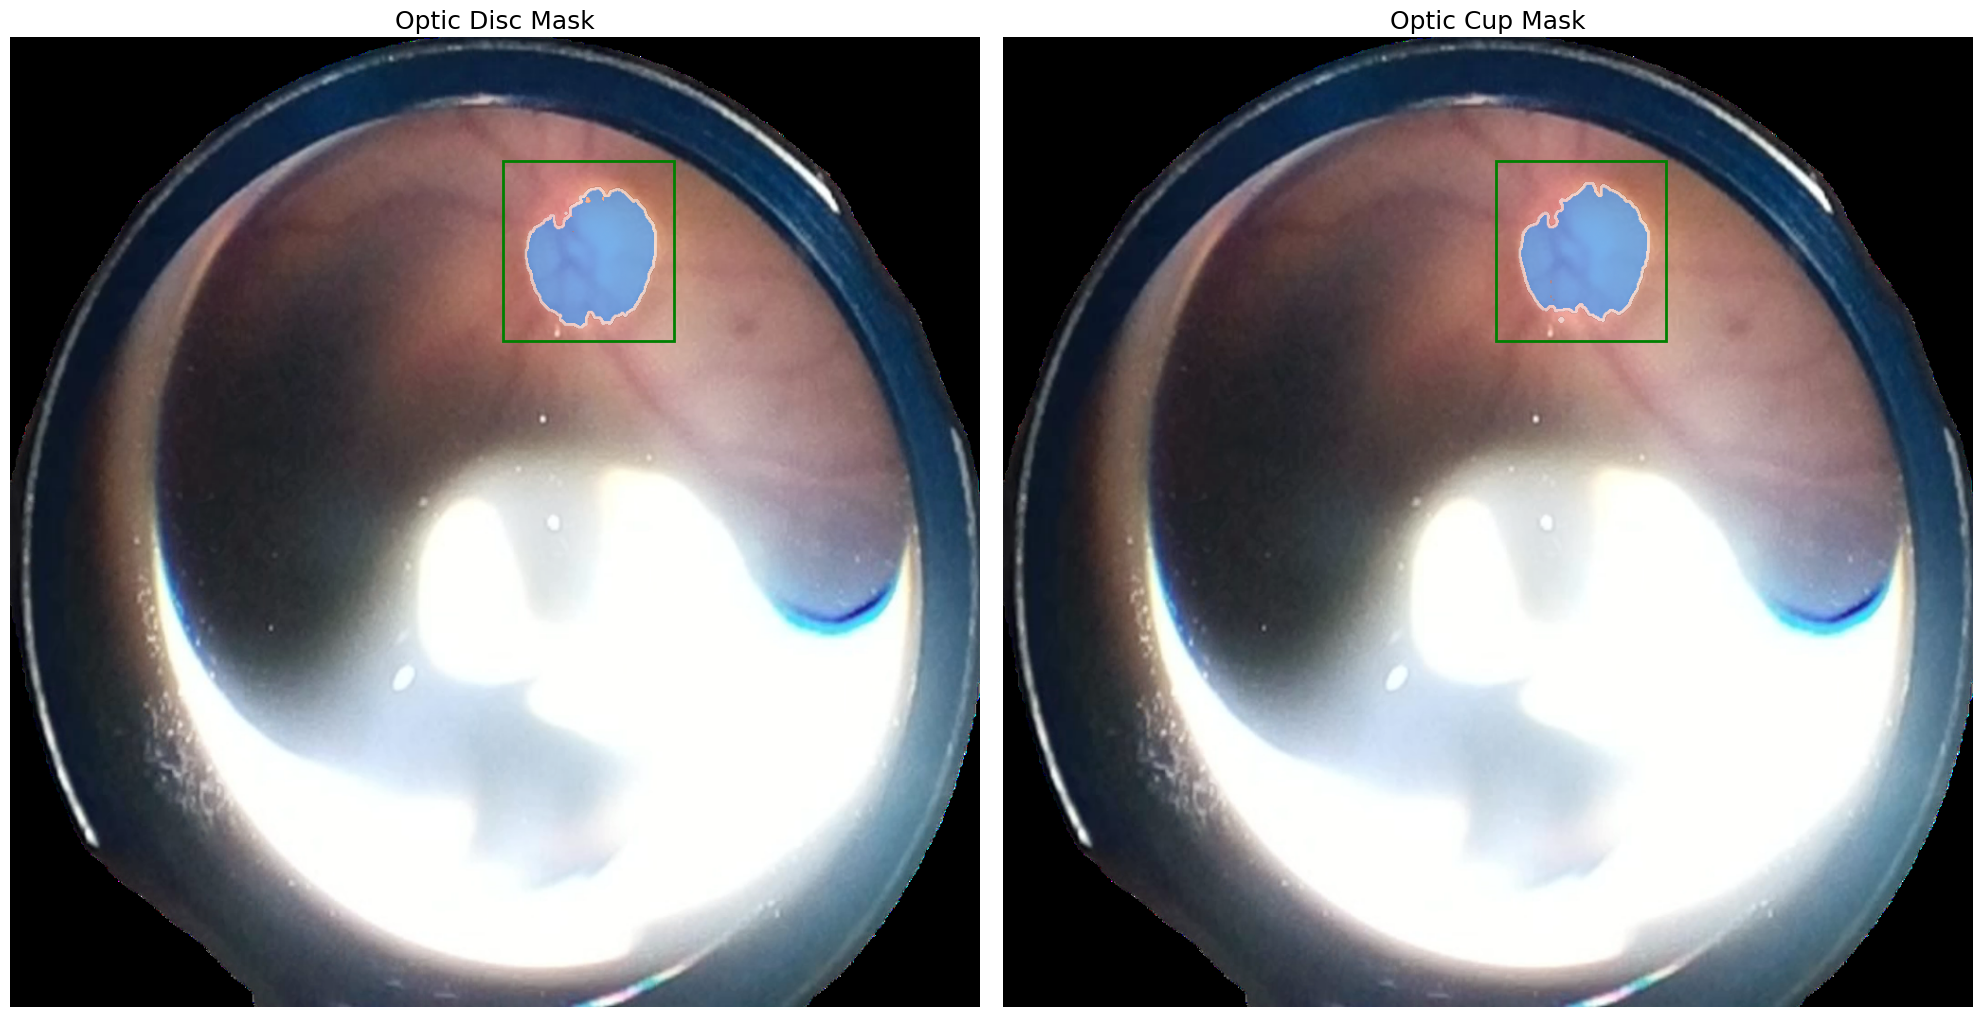

In [40]:
show_masks(img, masks, scores, box_coords=np.array([520, 130, 700, 320]))